In [1]:
import rclpy
import cv2
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd



In [2]:
from sensor_msgs.msg import Image, PointCloud2
from geometry_msgs.msg import Pose
from rclpy.callback_groups import ReentrantCallbackGroup
from threading import Thread
import pymoveit2 
from pymoveit2 import MoveIt2, GripperInterface
import time

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from py_cylinder_fitting import BestFitCylinder
from skspatial.objects import Points

import copy

ModuleNotFoundError: No module named 'pymoveit2'

In [3]:
#import pyntcloud


In [4]:
rclpy.init()
node = rclpy.create_node("jupyter")
img_msg = None
depth = None
points = None

def depth_listener_callback(data):
    global depth
    depth = data

def points_listener_callback(data):
    global points
    points = data

def image_callback(data):
    global img_msg
    img_msg = data

subs = [node.create_subscription(
            Image,
            '/realsense/'+n,
            cb,
            10) for (n, cb) in [("color/image_raw", image_callback),
                                ("aligned_depth_to_color/image_raw", depth_listener_callback),
                                ]]

p_sub = node.create_subscription(PointCloud2, '/realsense/depth/color/points', points_listener_callback,10)

callback_group = ReentrantCallbackGroup()

moveit2 = MoveIt2(node=node, 
                  joint_names=['ur5_shoulder_pan_joint', 'ur5_shoulder_lift_joint',
                               'ur5_elbow_joint','ur5_wrist_1_joint',
                               'ur5_wrist_2_joint','ur5_wrist_3_joint'],
                  base_link_name='ur5_base_link',
                  end_effector_name='gripper',
                  group_name='arm',
                  callback_group=callback_group
                 )

  # Create gripper interface
gripper_interface = GripperInterface(
        node=node,
        gripper_joint_names=['finger_joint'],
        open_gripper_joint_positions=[0.0],
        closed_gripper_joint_positions=[0.07],
        gripper_group_name='gripper',
        callback_group=callback_group,
        gripper_command_action_name="gripper_controller/follow_joint_trajectory",
    )

# Spin the node in background thread(s) and wait a bit for initialization
executor = rclpy.executors.MultiThreadedExecutor(4)
executor.add_node(node)
executor_thread = Thread(target=executor.spin, daemon=True, args=())
executor_thread.start() # Using threads, our node will keep spinning while we code 

time.sleep(5) # Give it 5 seconds to setup and recieve the first message

In [5]:
from tf2_ros import Buffer, TransformListener
tf_buffer = Buffer()
tf_listener = TransformListener(tf_buffer, node)

In [10]:
img_msg is None

True

In [8]:
# Assuming msg contains the image data
height = img_msg.height
width = img_msg.width
channels = img_msg.step // width
img = np.frombuffer(img_msg.data, dtype=np.uint8).reshape(height, width, channels)

plt.imshow(img)

AttributeError: 'NoneType' object has no attribute 'height'

In [ ]:
target_size = (352, 352)

res_img = cv2.resize(img, (224,224))

plt.imshow(res_img)
plt.show()


In [8]:
img[:224,:224,:].shape

(224, 224, 3)

In [9]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined", size={'height':224, 'width':224})
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [10]:
inputs = processor(text="a can of soda", images=[img], return_tensors="pt")

In [11]:
inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])

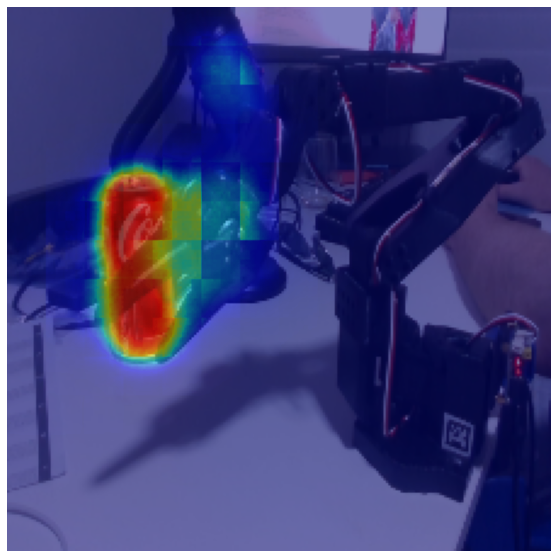

In [12]:
outputs = model(**inputs)
mask = outputs.logits.sigmoid().detach().cpu().numpy()[0,:,:]

plt.figure(figsize=(10, 10))
plt.imshow(res_img)
plt.imshow(mask, alpha=0.5, cmap="jet")
plt.axis("off")
plt.show()

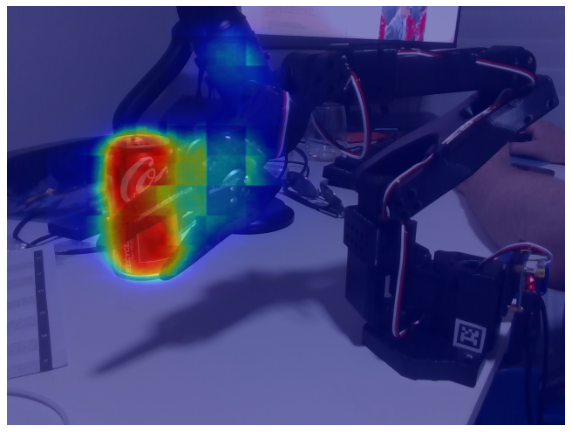

In [13]:
full_mask = cv2.resize(mask, (640,480))
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.imshow(full_mask, alpha=0.5, cmap="jet")
#plt.imshow(depth_image[:352,:352], alpha=0.5)
plt.axis("off")
plt.show()

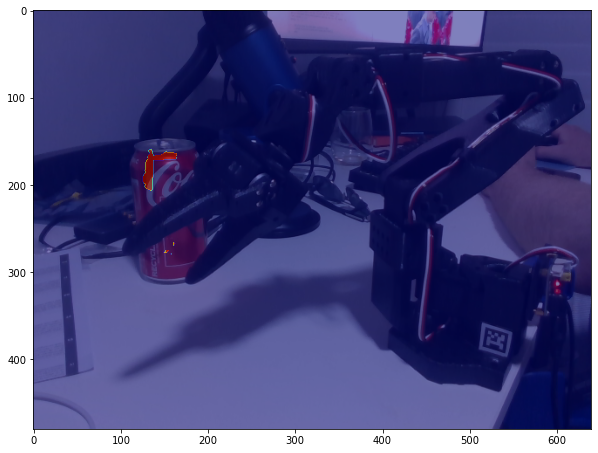

In [14]:
filtered_mask = full_mask.copy()
filtered_mask[full_mask < 0.9] =0

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.imshow(filtered_mask, alpha=0.5, cmap="jet")
plt.show()

In [15]:
depth_image = np.frombuffer(depth.data, dtype=np.uint16).reshape(depth.height, depth.width)

def depth_to_point_cloud(depth_image, fx, fy, cx, cy):
    height, width = depth_image.shape
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    xx, yy = np.meshgrid(x, y)
    z = depth_image /1000

    x = (xx - cx) * z / fx
    y = (yy - cy) * z / fy

    points = np.stack((x, y, z), axis=-1) #.reshape(-1, 3)
    return points

depth_points = depth_to_point_cloud(depth_image, fx=384.187, fy=384.187, cx=312.679, cy=245.36)

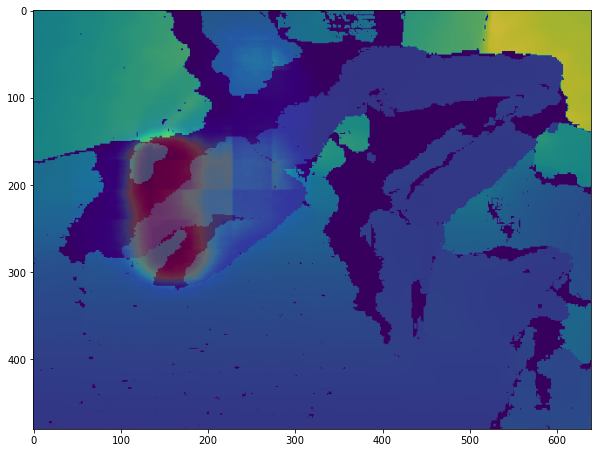

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(depth_image)
plt.imshow(full_mask, alpha=0.2, cmap="jet")
#plt.imshow(depth_image[:352,:352], alpha=0.5)
plt.show()

In [17]:
img.shape

(480, 640, 3)

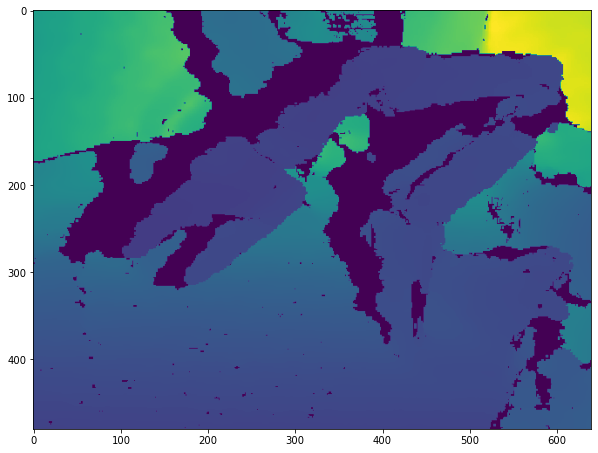

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(depth_image)
#plt.imshow(depth_image[:352,:352], alpha=0.5)
plt.show()

In [19]:
depth_points

array([[[-0.73167083, -0.57414395,  0.899     ],
        [-0.73095336, -0.57542124,  0.901     ],
        [-0.73022548, -0.57669853,  0.903     ],
        ...,
        [ 1.25275547, -0.94775263,  1.484     ],
        [ 1.25661817, -0.94775263,  1.484     ],
        [ 1.26048087, -0.94775263,  1.484     ]],

       [[-0.73167083, -0.57180394,  0.899     ],
        [-0.73014209, -0.57243998,  0.9       ],
        [-0.73022548, -0.57434812,  0.903     ],
        ...,
        [ 1.25275547, -0.94388993,  1.484     ],
        [ 1.25661817, -0.94388993,  1.484     ],
        [ 1.26048087, -0.94388993,  1.484     ]],

       [[-0.73167083, -0.56946393,  0.899     ],
        [-0.73014209, -0.57009737,  0.9       ],
        [-0.73022548, -0.5719977 ,  0.903     ],
        ...,
        [ 1.25275547, -0.94002723,  1.484     ],
        [ 1.25661817, -0.94002723,  1.484     ],
        [ 1.26048087, -0.94002723,  1.484     ]],

       ...,

       [[-0.26369449,  0.19535112,  0.324     ],
        [-0

In [20]:
filtered_mask[np.isfinite(depth_points).all(axis=2)==False] = 0

cylinder_points = depth_points[filtered_mask > 0.90]

finite_depth_points = cylinder_points


In [21]:
finite_depth_points.shape

(590, 3)

In [22]:
points_np = finite_depth_points[:,:]
points_np = points_np[points_np.sum(axis=1) != 0, :]
points_np.shape

(379, 3)

In [23]:
points_np

array([[-0.22707793, -0.11037011,  0.491     ],
       [-0.22869861, -0.10864772,  0.489     ],
       [-0.22742579, -0.10864772,  0.489     ],
       ...,
       [-0.20869738,  0.04109551,  0.499     ],
       [-0.20739854,  0.04109551,  0.499     ],
       [-0.2009043 ,  0.0436932 ,  0.499     ]])

In [24]:
pc2


NameError: name 'pc2' is not defined

In [ ]:
%matplotlib qt

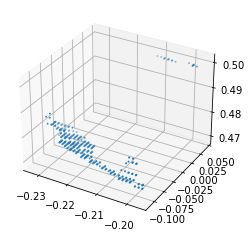

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], s=1)
plt.show()

In [ ]:
points_np[::1000,:].shape

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def unit_vector_to_quaternion(unit_vector):
    """
    Convert a 3D unit vector to a quaternion representing the rotation from [0,0,1] to that vector.

    :param unit_vector: numpy array or list [x, y, z] representing a unit vector
    :return: numpy quaternion array [w, x, y, z]
    """
    # Ensure the vector is a numpy array
    unit_vector = np.array(unit_vector)
    magnitude = np.linalg.norm(unit_vector)
    unit_vector = unit_vector/magnitude
    
    # Reference vector (z-axis)
    reference = np.array([0, 0, 1])
    
    # If the vector is already pointing up or down, no rotation is needed
    if np.allclose(unit_vector, reference) or np.allclose(unit_vector, -reference):
        return np.array([1.0, 0.0, 0.0, 0.0])  # Identity quaternion

    # Calculate the rotation axis using cross product
    rotation_axis = np.cross(reference, unit_vector)
    
    # Normalize the rotation axis
    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
    
    # Calculate the angle using dot product
    dot_product = np.dot(reference, unit_vector)
    angle = np.arccos(dot_product)
    
    # Create quaternion from axis-angle representation
    rotation = R.from_rotvec(angle * rotation_axis)
    quaternion = rotation.as_quat()  # This gives [x, y, z, w]; we need [w, x, y, z]
    return np.roll(quaternion, 1)  # Roll to get [w, x, y, z]


In [ ]:
points = Points(points_np[::1000,:])
best_fit_cylinder = BestFitCylinder(points)

# Get the cylinder parameters
cylinder_center = best_fit_cylinder.point
cylinder_axis = best_fit_cylinder.vector
cylinder_radius = best_fit_cylinder.radius

print("Cylinder Center:", cylinder_center)
print("Cylinder Axis:", cylinder_axis)
print("Cylinder Radius:", cylinder_radius)

cylinder_height = (cylinder_axis[0]**2 + cylinder_axis[1]**2 + cylinder_axis[2]**2) ** 0.5

print("Cylinder height: ", cylinder_height)


In [26]:
point_mean = points_np.mean(axis=0)

In [28]:
frame_id = 'realsense_depth_optical_frame'
# Define the pose of the cylinder
#o = unit_vector_to_quaternion(cylinder_axis)
# Define the pose of the cylinder
cylinder_pose = Pose()
cylinder_pose.position.x = point_mean[0] #cylinder_center[0]
cylinder_pose.position.y = point_mean[1] #cylinder_center[1]
cylinder_pose.position.z = point_mean[2] #cylinder_center[2]
cylinder_pose.orientation.w = 1.0  # Assuming no rotation

tf = tf_buffer.lookup_transform(frame_id, 'base_footprint', time=rclpy.time.Time())
 
cylinder_pose.orientation.x = tf.transform.rotation.x
cylinder_pose.orientation.y = tf.transform.rotation.y

cylinder_pose.orientation.z = tf.transform.rotation.z

cylinder_pose.orientation.w = tf.transform.rotation.w



In [30]:
moveit2.add_collision_cylinder('soda', height=0.09, 
                               radius=0.05, pose=cylinder_pose, 
                               frame_id=frame_id)

moveit2.planner_id = 'geometric::RRTConnect'

In [ ]:
res = moveit2.allow_collisions('soda', allow=True)

In [ ]:
tf = tf_buffer.lookup_transform('base_footprint','realsense_color_optical_frame', time=rclpy.time.Time())

In [ ]:
tf.transform.rotation


In [ ]:
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

# Given quaternion
x, y, z, w = o

# Create a rotation object from the quaternion
rotation = R.from_quat([x, y, z, w])

# Define some points to represent our axes (before rotation)
origin = np.array([0, 0, 0])
x_axis = np.array([1, 0, 0])
y_axis = np.array([0, 1, 0])
z_axis = np.array([0, 0, 1])

# Apply the rotation
x_axis_rotated = rotation.apply(x_axis)
y_axis_rotated = rotation.apply(y_axis)
z_axis_rotated = rotation.apply(z_axis)

# Set up the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original axes
ax.plot([origin[0], x_axis[0]], [origin[1], x_axis[1]], [origin[2], x_axis[2]], 'r-', label='X original')
ax.plot([origin[0], y_axis[0]], [origin[1], y_axis[1]], [origin[2], y_axis[2]], 'g-', label='Y original')
ax.plot([origin[0], z_axis[0]], [origin[1], z_axis[1]], [origin[2], z_axis[2]], 'b-', label='Z original')

# Plot the rotated axes
ax.plot([origin[0], x_axis_rotated[0]], [origin[1], x_axis_rotated[1]], [origin[2], x_axis_rotated[2]], 'r--', label='X rotated')
ax.plot([origin[0], y_axis_rotated[0]], [origin[1], y_axis_rotated[1]], [origin[2], y_axis_rotated[2]], 'g--', label='Y rotated')
ax.plot([origin[0], z_axis_rotated[0]], [origin[1], z_axis_rotated[1]], [origin[2], z_axis_rotated[2]], 'b--', label='Z rotated')

# Add labels and make the plot look nice
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.legend()

# Ensure the plot is equal in all directions
ax.set_box_aspect((1,1,1))

plt.show()

In [3]:
plt.show?